# Target


*   Lower the number of parameters under 10k.
*   Train the model for less than 15 epochs.
*   Try to achieve 99.4% accuracy.

# Result

*   Params = 9,922
*   Best Train Accuracy = 98.46% at 14th epoch
*   Best Test Accuracy = 99.36% at 14th epoch

# Analysis

*   The model is underfitting.
*   The model nears the desired accuracy. If we train it for more epochs, it may reach the desired accuracy. To accomplish our goal, we will try to introduce some transforms in further codes.


In [1]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
!pip install torchsummary

## Model

In [2]:
dropout_value = 0.10

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, padding=0),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU() 
        ) # output_size = 26

        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=20, kernel_size=3, padding=0),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU() 
        ) # output_size = 24

        # transition block 
        self.conv_1_1 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1), 
            nn.MaxPool2d(2, 2),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 12
        # end

        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=10, kernel_size=3, padding=0),
            nn.BatchNorm2d(10),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 10

        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=3, padding = 0),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 8

        #
        # self.conv5 = nn.Sequential(
        #     nn.Conv2d(in_channels=16, out_channels=16, kernel_size=1), 
        #     nn.BatchNorm2d(16),
        #     nn.Dropout(dropout_value),
        #     nn.ReLU()
        # )

        self.conv6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 0), 
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6

        self.conv7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, padding = 1),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value),
            nn.ReLU()
        ) # output_size = 6( padding = 1)

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size = 6)
        ) # output_size = 1

        # final FC layer (read fully convolutional, not fully connected)
        self.conv8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=20, kernel_size=1),
            nn.BatchNorm2d(20),
            nn.Dropout(dropout_value),
            nn.ReLU()
        )

        self.conv9 = nn.Sequential(
            nn.Conv2d(in_channels=20, out_channels=10, kernel_size=1)
        )

        self.dropout = nn.Dropout(dropout_value)
    
    def forward(self, x):
            x = self.conv1(x)
            x = self.conv2(x)
            x = self.conv_1_1(x)
            x = self.conv3(x)
            x = self.conv4(x)
            # x = self.conv5(x)
            x = self.conv6(x)
            x = self.conv7(x)
            x = self.gap(x)
            x = self.conv8(x)
            x = self.conv9(x)

            x = x.view(-1, 10)
            return F.log_softmax(x)


## Model Summary

In [3]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 10, 26, 26]             100
       BatchNorm2d-2           [-1, 10, 26, 26]              20
           Dropout-3           [-1, 10, 26, 26]               0
              ReLU-4           [-1, 10, 26, 26]               0
            Conv2d-5           [-1, 20, 24, 24]           1,820
       BatchNorm2d-6           [-1, 20, 24, 24]              40
           Dropout-7           [-1, 20, 24, 24]               0
              ReLU-8           [-1, 20, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             210
        MaxPool2d-10           [-1, 10, 12, 12]               0
      BatchNorm2d-11           [-1, 10, 12, 12]              20
          Dropout-12           [-1, 10, 12, 12]               0
             ReLU-13           [-1, 10, 12, 12]               0
           Conv2d-14           [-1, 10,

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [4]:
torch.cuda.get_device_name(0)

'Tesla T4'

## Data loading and transformations

In [6]:
torch.manual_seed(1) # for consistent output
batch_size = 64

kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

# train data
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                    transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,)) # mean, std of the data
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)

# test data
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                        transforms.ToTensor(),
                        transforms.Normalize((0.1307,), (0.3081,))
                    ])),
    batch_size=batch_size, shuffle=True, **kwargs)


Extracting ../data/MNIST/raw/train-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/train-labels-idx1-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-images-idx3-ubyte.gz to ../data/MNIST/raw


Extracting ../data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ../data/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


## Train and Test functions

In [7]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad() # setting the gradients to zero after every backprop step
    y_pred = model(data) # predicting the values
    loss = F.nll_loss(y_pred, target) # calculating the loss using negative loss likelihood
    train_losses.append(loss)
    loss.backward() # backpropagation
    optimizer.step()
    pred = y_pred.argmax(dim=1, keepdim=True) # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)
    accuracy = 100. * correct / processed

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100. * correct / processed:0.2f}')
    train_acc.append(100. * correct / processed)
    # return accuracy

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad(): # since we do not want to compute gradients on the test data, we use torch.no_grad()
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

## Training and Testing

In [8]:

model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

for epoch in range(1, 15):
    print('Epoch:',  epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch: 1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:99: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
Loss=0.45540010929107666 Batch_id=937 Accuracy=89.21: 100%|██████████| 938/938 [00:18<00:00, 49.89it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0796, Accuracy: 9763/10000 (97.63%)

Epoch: 2


Loss=0.11606652289628983 Batch_id=937 Accuracy=96.64: 100%|██████████| 938/938 [00:18<00:00, 50.76it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0444, Accuracy: 9877/10000 (98.77%)

Epoch: 3


Loss=0.2581104636192322 Batch_id=937 Accuracy=97.36: 100%|██████████| 938/938 [00:18<00:00, 50.72it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0371, Accuracy: 9889/10000 (98.89%)

Epoch: 4


Loss=0.009594163857400417 Batch_id=937 Accuracy=97.67: 100%|██████████| 938/938 [00:18<00:00, 51.56it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0327, Accuracy: 9905/10000 (99.05%)

Epoch: 5


Loss=0.010832589119672775 Batch_id=937 Accuracy=97.87: 100%|██████████| 938/938 [00:18<00:00, 51.58it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0304, Accuracy: 9901/10000 (99.01%)

Epoch: 6


Loss=0.11480490863323212 Batch_id=937 Accuracy=98.06: 100%|██████████| 938/938 [00:17<00:00, 52.39it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0274, Accuracy: 9915/10000 (99.15%)

Epoch: 7


Loss=0.08915480226278305 Batch_id=937 Accuracy=98.11: 100%|██████████| 938/938 [00:17<00:00, 52.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0279, Accuracy: 9912/10000 (99.12%)

Epoch: 8


Loss=0.01611347123980522 Batch_id=937 Accuracy=98.14: 100%|██████████| 938/938 [00:17<00:00, 52.86it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0237, Accuracy: 9926/10000 (99.26%)

Epoch: 9


Loss=0.005152248311787844 Batch_id=937 Accuracy=98.29: 100%|██████████| 938/938 [00:18<00:00, 51.47it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0253, Accuracy: 9918/10000 (99.18%)

Epoch: 10


Loss=0.030080502852797508 Batch_id=937 Accuracy=98.35: 100%|██████████| 938/938 [00:17<00:00, 52.25it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0257, Accuracy: 9926/10000 (99.26%)

Epoch: 11


Loss=0.02646704949438572 Batch_id=937 Accuracy=98.32: 100%|██████████| 938/938 [00:17<00:00, 52.42it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0227, Accuracy: 9932/10000 (99.32%)

Epoch: 12


Loss=0.04345594346523285 Batch_id=937 Accuracy=98.41: 100%|██████████| 938/938 [00:17<00:00, 52.69it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0263, Accuracy: 9920/10000 (99.20%)

Epoch: 13


Loss=0.3837903141975403 Batch_id=937 Accuracy=98.39: 100%|██████████| 938/938 [00:17<00:00, 52.24it/s]
  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0223, Accuracy: 9933/10000 (99.33%)

Epoch: 14


Loss=0.013196919113397598 Batch_id=937 Accuracy=98.46: 100%|██████████| 938/938 [00:17<00:00, 52.17it/s]



Test set: Average loss: 0.0241, Accuracy: 9936/10000 (99.36%)



## Plotting

Text(0.5, 1.0, 'Test Accuracy')

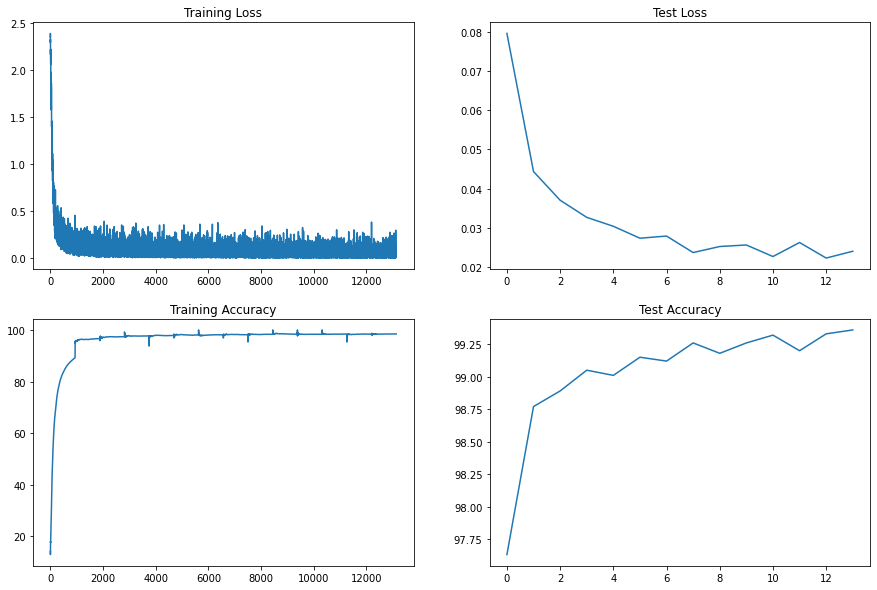

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")